In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import json
import numpy as np
from features import merge_entries
from utills import chunker, cartesian_product
import glob
from tqdm.auto import trange, tqdm

In [3]:
import seaborn as sns

In [4]:
from sklearn.metrics import roc_curve, auc

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib notebook
style.use('seaborn-whitegrid')


In [6]:
COMPUTED_DATA_PATH = '../temp_data/gpt3/'
MODEL_DIR = '../temp_data/pan/'
PAN_MODEL_PATH = '../temp_data/pan/large_model.p'

In [9]:
def predict(docs_1, docs_2, clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc, clf, transformer, scaler, secondary_scaler, chunk_sz):
    probs_nc = []

    inter_probs_mean = []
    inter_probs_std = []

    intraA_probs_mean = []
    intraA_probs_std = []

    intraB_probs_mean = []
    intraB_probs_std = []
    pred_lengths = []

    for i in trange(len(docs_1)):
        doc_1 = docs_1[i]
        doc_2 = docs_2[i]
        l = []
        docs_merged_1 = [merge_entries(c) for c in list(chunker(doc_1, chunk_sz))]
        docs_merged_2 = [merge_entries(c) for c in list(chunker(doc_2, chunk_sz))]

        X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
        X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

        idxs = cartesian_product(range(len(X_1)), range(len(X_2)))
        x_diff = secondary_scaler.transform(np.abs(X_1[idxs[:, 0]] - X_2[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]

        inter_probs_mean.append(p.mean())
        inter_probs_std.append(p.std())
        l.append(len(p))

        idxs = cartesian_product(range(len(X_1)), range(len(X_1)))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(X_1[idxs[:, 0]] - X_1[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraA_probs_mean.append(p.mean())
            intraA_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraA_probs_mean.append(np.nan)
            intraA_probs_std.append(np.nan)
            l.append(0)

        idxs = cartesian_product(range(len(X_2)), range(len(X_2)))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(X_2[idxs[:, 0]] - X_2[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraB_probs_mean.append(p.mean())
            intraB_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraB_probs_mean.append(np.nan)
            intraB_probs_std.append(np.nan)
            l.append(0)

        pred_lengths.append(l)


        X_1 = scaler_nc.transform(transformer_nc.transform([merge_entries(doc_1)]).todense())
        X_2 = scaler_nc.transform(transformer_nc.transform([merge_entries(doc_2)]).todense())
        p = clf_nc.predict_proba(secondary_scaler_nc.transform(np.abs(X_1 - X_2)))[0, 1]
        probs_nc.append(p)


    inter_probs_mean = np.array(inter_probs_mean)
    intraA_probs_mean = np.array(intraA_probs_mean)
    intraB_probs_mean = np.array(intraB_probs_mean)
    inter_probs_std = np.array(inter_probs_std)
    intraA_probs_std = np.array(intraA_probs_std)
    intraB_probs_std = np.array(intraB_probs_std)
    pred_lengths = np.array(pred_lengths)


    probs_nc = np.array(probs_nc)

    n_a = pred_lengths[:, 0]
    n_b = pred_lengths[:, 1]
    n_ab = pred_lengths[:, 2]

    intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
    intra_probs_std = (
            n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
            n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
        ) / (n_a + n_b)


    pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
    pooled_std = (
            (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
            n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
        ) / (n_a + n_b + n_ab)

    aggr_score = probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))
    return aggr_score

In [7]:
def predict_pan(docs_1, docs_2, clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan):
    docs_merged_1 = [merge_entries(c) for c in docs_1]
    docs_merged_2 = [merge_entries(c) for c in docs_2]
    
    X_1 = scaler_pan.transform(transformer_pan.transform(docs_merged_1).todense())
    X_2 = scaler_pan.transform(transformer_pan.transform(docs_merged_2).todense())
    
    p = clf_pan.predict_proba(secondary_scaler_pan.transform(np.abs(X_1 - X_2)))[:, 1]
    return p

Load Data
===

In [14]:
human_docs_1 = []
human_docs_2 = []
chatgpt_docs_1 = []
chatgpt_docs_2 = []

pair_ids_chatgpt = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_chatgpt_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(d['pair'][0]['human'])
            human_docs_2.append(d['pair'][1]['human'])
            
            chatgpt_docs_1.append(d['pair'][0]['ai'])
            chatgpt_docs_2.append(d['pair'][1]['ai'])
            pair_ids_chatgpt.append(d['id'])
print('Read:', len(human_docs_1))

Read: 48


In [15]:
human_docs_1 = []
human_docs_2 = []
gpt3_docs_1 = []
gpt3_docs_2 = []

pair_ids_gpt3 = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_gpt3_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(d['pair'][0]['human'])
            human_docs_2.append(d['pair'][1]['human'])
            
            gpt3_docs_1.append(d['pair'][0]['ai'])
            gpt3_docs_2.append(d['pair'][1]['ai'])
            pair_ids_gpt3.append(d['id'])
print('Read:', len(human_docs_1))

Read: 93


Load Models
===

In [12]:
with open(MODEL_DIR + 'model.p', 'rb') as f:
    (clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc) = pickle.load(f)

# Chunked model
with open(MODEL_DIR + 'split_models/model_5.p', 'rb') as f:
    (clf, transformer, scaler, secondary_scaler) = pickle.load(f)
chunk_sz=5

In [13]:
with open(PAN_MODEL_PATH, 'rb') as f:
    (clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan) = pickle.load(f)

Stats
====

In [17]:
print('ChatGP3 Tokens:', np.mean([len(merge_entries(d)['tokens']) for d in (chatgpt_docs_1 + chatgpt_docs_2)]))
print('GPT3 tokens:', np.mean([len(merge_entries(d)['tokens']) for d in (gpt3_docs_1 + gpt3_docs_2)]))

ChatGP3 Tokens: 5156.770833333333
GPT3 tokens: 5775.881720430108


Predict
===

GPT3 vs ChatGPT3, generated from the same author
---

In [28]:
common_pairs = np.intersect1d(pair_ids_chatgpt, pair_ids_gpt3)

In [38]:
chatgpt_docs_1_common = [chatgpt_docs_1[pair_ids_chatgpt.index(idx)] for idx in common_pairs]
chatgpt_docs_2_common = [chatgpt_docs_2[pair_ids_chatgpt.index(idx)] for idx in common_pairs]


gpt3_docs_1_common = [gpt3_docs_1[pair_ids_gpt3.index(idx)] for idx in common_pairs]
gpt3_docs_2_common = [gpt3_docs_2[pair_ids_gpt3.index(idx)] for idx in common_pairs]

In [44]:
# probs_ha1 = predict(
#     human_docs_1, ai_docs_1,
#     clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
#     clf, transformer, scaler, secondary_scaler, chunk_sz
# )
# probs_ha1.mean()

probs_chatgpt_gpt3_1 = predict_pan(
    chatgpt_docs_1_common, gpt3_docs_1_common,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_chatgpt_gpt3.mean()

0.7798626702842092

In [41]:
probs_chatgpt_gpt3_2 = predict_pan(
    chatgpt_docs_2_common, gpt3_docs_2_common,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_chatgpt_gpt3_2.mean()

0.7689438326144075

In [45]:
probs_chatgpt_gpt3 = np.concatenate([probs_chatgpt_gpt3_1, probs_chatgpt_gpt3_2])
probs_chatgpt_gpt3.mean()

0.7744032514493084

AI vs AI, based on texts generated from different human authors
----

In [46]:
# shuffled_idxs = np.random.permutation(len(ai_docs_1))
# probs_aa_shuffled = predict(
#     np.array(ai_docs_1)[shuffled_idxs], np.array(ai_docs_2),
#     clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
#     clf, transformer, scaler, secondary_scaler, chunk_sz
# )
# probs_aa_shuffled.mean()

shuffled_idxs = np.random.permutation(len(chatgpt_docs_1_common))
probs_chatgpt_gpt3_shuffled = predict_pan(
    np.array(chatgpt_docs_1_common)[shuffled_idxs], np.array(gpt3_docs_1_common),
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_chatgpt_gpt3_shuffled.mean()

0.49369254779884214

In [47]:
style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=7

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  

<IPython.core.display.Javascript object>


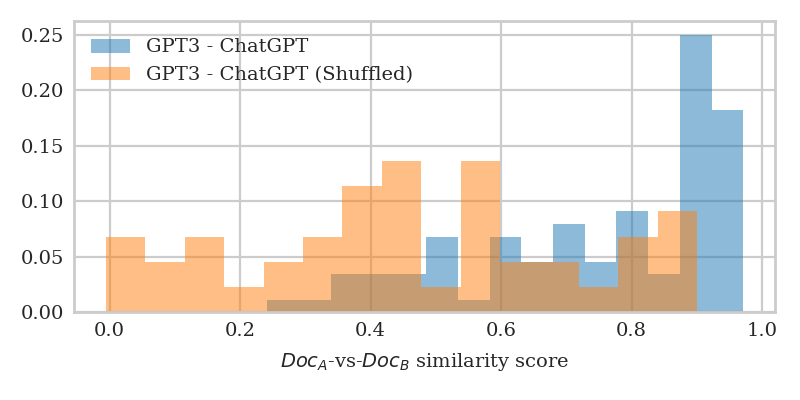

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

nbins = 15
arr = probs_chatgpt_gpt3
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[0])

arr = probs_chatgpt_gpt3_shuffled
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[1])
# _ = ax[0].hist(aggr_score[labels==False], bins=500, alpha=0.5)
ax.set_xlabel('$Doc_A$-vs-$Doc_B$ similarity score')
ax.legend(labels=['GPT3 - ChatGPT', 'GPT3 - ChatGPT (Shuffled)'], loc='best')
# ax.title.set_text('Single Document Pair Model')


plt.tight_layout()